#### Package installations
Uncomment if use GPU rent services

In [1]:
# !pip3 install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
# !pip install nuscenes-devkit

In [3]:
# # Fix error : libGL.so.1: cannot open shared object file: No such file or directory
# !apt install -y libgl1-mesa-glx

In [1]:
import torch

print(torch.cuda.is_available())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on ', device)
print(f"Device count: {torch.cuda.device_count()}")

True
Running on  cuda:0
Device count: 1


In [2]:
import os
import zipfile

CURRENT_PATH = f'{os.getcwd()}/'

#### Unzip nuScenes dataset

In [ ]:
DatasetName = 'Dataset.zip'

print(f'{CURRENT_PATH}{DatasetName}')

with zipfile.ZipFile(DatasetName, 'r') as zip_ref:
    zip_ref.extractall(f'{CURRENT_PATH}{DatasetName}')

#### NuScenes initialization

In [3]:
from nuscenes import NuScenes
from nuscenes.prediction import PredictHelper
from nuscenes.eval.prediction.splits import get_prediction_challenge_split

import matplotlib.pyplot as plt

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = 'Dataset/'

history_length = 2
prediction_length = 6

# Use v1.0-trainval or v1.0-mini
nusc = NuScenes('v1.0-trainval', dataroot=DATAROOT, verbose=False)
helper = PredictHelper(nusc)

In [4]:
train = get_prediction_challenge_split("train", dataroot=DATAROOT)
validation = get_prediction_challenge_split("train_val", dataroot=DATAROOT)
test = get_prediction_challenge_split("val", dataroot=DATAROOT)

print(f"Train len: {len(train)}\nVal len: {len(validation)}\nTest len: {len(test)}")

Train len: 32186
Val len: 8560
Test len: 9041


In [5]:
train = train[:5000]
validation = validation[:1000]
test = test[:1000]

In [6]:
import pickle

PATH_TO_EPSILON_8_SET = f"{DATAROOT}prediction_trajectory_sets/epsilon_8.pkl"
trajectories_set_8 = pickle.load(open(PATH_TO_EPSILON_8_SET, 'rb'))
trajectories_set_8 = torch.Tensor(trajectories_set_8)

#### Init datasets and dataloaders

In [7]:
from torch.utils.data import DataLoader, Dataset

import numpy as np
from typing import List

from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

class NuscenesDataset(Dataset):
    def __init__(self, tokens: List[str], helper: PredictHelper):
        self.tokens = tokens
        self.static_layer_representation = StaticLayerRasterizer(helper)

    def __len__(self):
        return len(self.tokens)
    
    def __getitem__(self, index: int):

        token = self.tokens[index]
        instance_token, sample_token = token.split("_")

        image = self.static_layer_representation.make_representation(instance_token, sample_token)
        image = torch.Tensor(image).permute(2, 0, 1)

        # NaN Values processing
        def agent_param_processing(value):
            if np.isnan(value):
                return -1
            return value
        
        vel = helper.get_velocity_for_agent(instance_token, sample_token)
        vel = agent_param_processing(vel)
        
        accel = helper.get_acceleration_for_agent(instance_token, sample_token)
        accel = agent_param_processing(accel)
        
        heading_cr = helper.get_heading_change_rate_for_agent(instance_token, sample_token)
        heading_cr = agent_param_processing(heading_cr)
                
        agent_state_vector = torch.Tensor([vel, accel, heading_cr])

        ground_truth = helper.get_future_for_agent(instance_token, sample_token, prediction_length, in_agent_frame=True)

        # Convert to [batch_size, 1, 12, 2]
        # Because loss function need that format
        ground_truth = np.expand_dims(ground_truth, 0)

        return image, agent_state_vector, ground_truth

In [8]:
batch_size = 32

train_ds = NuscenesDataset(train, helper)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

train_val_ds = NuscenesDataset(validation, helper)
train_val_dl = DataLoader(train_ds, batch_size=batch_size * 2)

In [9]:
image, state, ground_truth = next(iter(train_dl))
print(image.size())
print(state.size())
print(ground_truth.size())

print("Preprocessing states:")
print(state)

torch.Size([32, 3, 500, 500])
torch.Size([32, 3])
torch.Size([32, 1, 12, 2])
Preprocessing states:
tensor([[ 4.9160e+00,  6.0225e-01, -2.6181e-02],
        [ 3.2307e+00, -1.2659e-02, -4.3603e-02],
        [ 4.7034e-01, -1.0000e+00, -3.1722e-02],
        [ 4.7608e-01,  8.1942e-01,  0.0000e+00],
        [ 5.2808e+00, -5.6937e-04, -1.7457e-02],
        [ 8.6915e+00, -3.2848e+00, -4.6554e-02],
        [ 5.5380e+00,  3.4385e-01, -3.4915e-02],
        [ 1.0562e+01,  5.0342e-01,  0.0000e+00],
        [ 4.8813e+00,  1.1300e+00,  0.0000e+00],
        [ 4.3621e+00, -3.9068e-01,  6.9910e-02],
        [ 7.7536e+00, -7.4776e-01, -2.9096e-02],
        [ 3.2334e-02, -4.3565e-03,  0.0000e+00],
        [ 2.0382e+00, -2.0613e-04,  0.0000e+00],
        [ 5.9205e+00, -5.7465e-01, -1.7439e-01],
        [ 6.2957e+00,  7.5329e-04,  1.7448e-02],
        [ 9.5768e-01, -1.0000e+00,  1.3094e-02],
        [ 3.7787e-02,  2.1290e-03,  0.0000e+00],
        [ 1.1805e+00,  1.2189e+00,  0.0000e+00],
        [ 7.4522e+0

#### Init ML prediction model

In [10]:
from nuscenes.prediction.models.backbone import ResNetBackbone
import torchvision.models as models

# Torchvision backbone
backbone = models.resnext50_32x4d(pretrained=True)

# Build-in backbone
#backbone = ResNetBackbone('resnet50')

# Set backbone to non-trainable
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False
        
set_parameter_requires_grad(backbone)

In [11]:
from torch.optim import SGD
from nuscenes.prediction.models.covernet import CoverNet, ConstantLatticeLoss

NUM_MODES = 64

model = CoverNet(backbone, num_modes=NUM_MODES)
model = model.to(device)

loss_function = ConstantLatticeLoss(trajectories_set_8)

c:\users\impor\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
# Pass to optimizer only params with requires_grad
params_to_update = []

for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

optimizer = SGD(params_to_update, lr=5e-4, momentum=0.9, weight_decay=5e-4)

	 head.0.weight
	 head.0.bias
	 head.1.weight
	 head.1.bias


In [13]:
from tqdm import tqdm
import copy
import time

def loss_batch(model, loss_func, img, state_vec, ground_truth, opt=None):
    img = img.to(device)
    state_vec = state_vec.to(device)
    ground_truth = ground_truth.to(device)
    
    predicted_logits = model(img, state_vec)
    loss = loss_func(predicted_logits, ground_truth)

    # For validation optimizer is None, thus we dont perform backprop
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    # Return losses and amount of items
    # print(f"{loss.item()}; {len(img)}")
    return loss.item(), len(img)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    best_loss = 999.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(epochs):
        start_epoch_time = time.time()
        print(f'Epoch: {epoch + 1}/{epochs}')
        print('-' * 10)
        
        model.train()

        for img, state_vec, gt in tqdm(train_dl):
            loss_batch(model, loss_func, img, state_vec, gt, opt)

        model.eval()
        print("Validation step")

        with torch.no_grad():
            # TODO: Using tqdm
            losses, nums = zip(
                *[loss_batch(model, loss_func, img, state_vec, gt) for img, state_vec, gt in valid_dl]
            )

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        # deep copy the model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"Epoch {epoch + 1}; Loss: {val_loss:0.2f}; Best: {best_loss:0.2f} Time: {(time.time() - start_epoch_time):0.2f} sec;")


In [14]:
# epochs = 3  # how many epochs to train for
# fit(epochs, model, loss_function, optimizer, train_dl, train_val_dl)

In [15]:
# torch.save(model.state_dict(), '/root/model.pth')

In [16]:
model.load_state_dict(torch.load('./model_data_5000_e25_loss_1-15.pth'))
model.eval()

CoverNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

#### Metrics

In [20]:
instance_token, sample_token = test[889].split("_")
print(instance_token, sample_token)

a9d16e62d4a0446faf00de7b0e5eca3a 6ce8c5bbf572476d84ade686fd21a09d


Vel: 5.055833473281852 
Accel: 1.4104343687377436 
Heading: -0.37242996343751095 



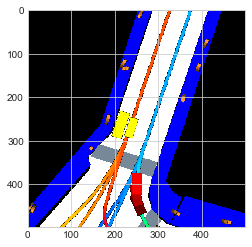

In [21]:
%matplotlib inline

from nuscenes.prediction.input_representation.static_layers import StaticLayerRasterizer
from nuscenes.prediction.input_representation.agents import AgentBoxesWithFadedHistory
from nuscenes.prediction.input_representation.interface import InputRepresentation
from nuscenes.prediction.input_representation.combinators import Rasterizer

static_layer_rasterizer = StaticLayerRasterizer(helper) #, layer_names=['traffic_light', 'road_segment'])
agent_rasterizer = AgentBoxesWithFadedHistory(helper, seconds_of_history=1)
mtp_input_representation = InputRepresentation(static_layer_rasterizer, agent_rasterizer, Rasterizer())

velocity = helper.get_velocity_for_agent(instance_token, sample_token)
acceleration = helper.get_acceleration_for_agent(instance_token, sample_token)
heading = helper.get_heading_change_rate_for_agent(instance_token, sample_token)

print(f"Vel: {velocity} \nAccel: {acceleration} \nHeading: {heading} \n")

anns = [ann for ann in nusc.sample_annotation if ann['instance_token'] == instance_token]

img = mtp_input_representation.make_input_representation(instance_token, sample_token)
plt.imshow(img)

In [22]:
image_tensor = torch.Tensor(img).permute(2, 0, 1).unsqueeze(0)
image_tensor = image_tensor.to(device)


agent_state_vector = torch.Tensor([[helper.get_velocity_for_agent(instance_token, sample_token),
                                    helper.get_acceleration_for_agent(instance_token, sample_token),
                                    helper.get_heading_change_rate_for_agent(instance_token, sample_token)]])
agent_state_vector = agent_state_vector.to(device)

logits = model(image_tensor, agent_state_vector)

Best 1; Probability: 4.218836307525635
Best 2; Probability: 4.034782409667969
Best 3; Probability: 3.983957290649414
Best 4; Probability: 3.6945090293884277
Best 5; Probability: 3.185006856918335
Best 6; Probability: 3.104950189590454
Best 7; Probability: 2.7638437747955322
Best 8; Probability: 2.695248603820801
Best 9; Probability: 2.6345322132110596
Best 10; Probability: 2.5761964321136475


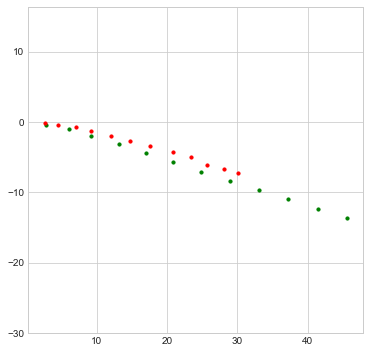

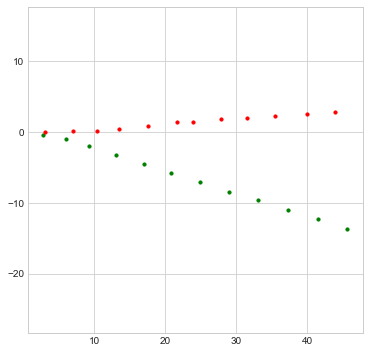

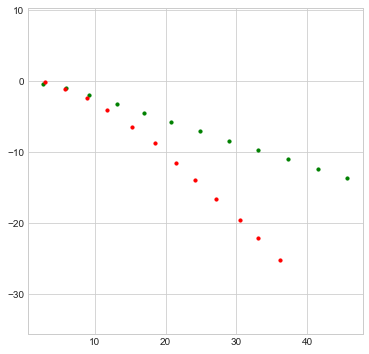

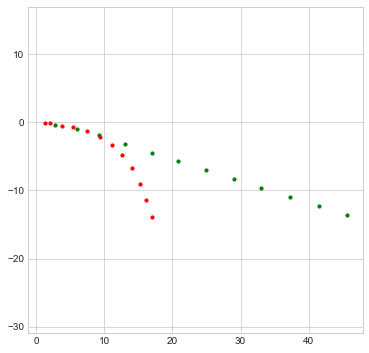

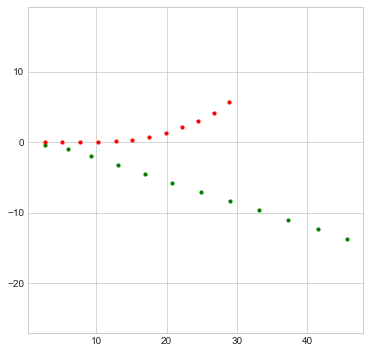

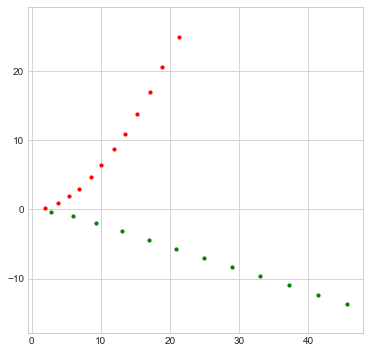

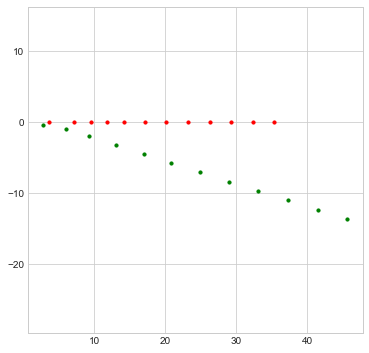

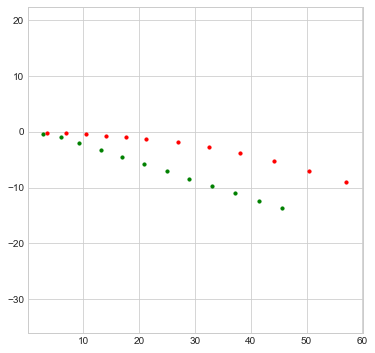

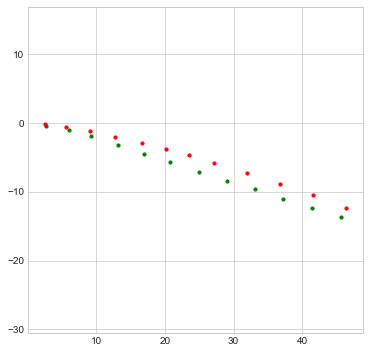

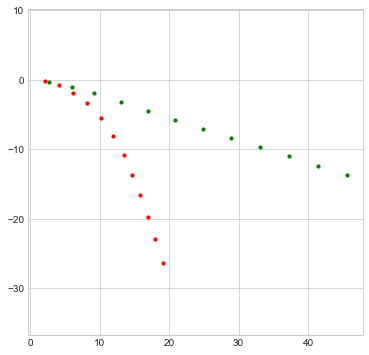

In [23]:
def PlotPathWithPrediction(gt, predict):
  plt.figure(figsize=(6, 6))

  plt.scatter(gt[:, 1], -gt[:, 0], c='g', s=10)
  plt.scatter(predict[:, 1], -predict[:, 0], c='r', s=10)

  # Keep aspect ratio of axis
  plt.axis('equal')
  plt.show()


local_future_path = helper.get_future_for_agent(instance_token, sample_token, seconds=prediction_length, in_agent_frame=True)

sorted_logits_indexes = logits.argsort(descending=True)
sorted_trajectories = trajectories_set_8[sorted_logits_indexes][0]

for i in range(10):
  print(f"Best {i + 1}; Probability: {logits[0][sorted_logits_indexes[0][i]]}")
  PlotPathWithPrediction(local_future_path, sorted_trajectories[i])

In [24]:
stacked_trajs = trajectories_set_8.numpy()

N = 64
stacked_ground_truth = np.empty((N, 12, 2))
for i in range(N):
    stacked_ground_truth[i] = local_future_path

mode_probabilities = np.array([logits.cpu().detach().numpy()[0]])

# print(stacked_trajs.shape())
# print(stacked_ground_truth.shape())
# print(mode_probabilities.shape())

In [25]:
import nuscenes.eval.prediction.metrics as metrics

a = metrics.min_fde_k(stacked_trajs, stacked_ground_truth, mode_probabilities)
a


array([[16.8740421 , 16.61541837, 14.92938854, 14.92938854, 14.92938854,
        14.92938854, 14.92938854, 12.37939875,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ,
         1.4818847 ,  1.4818847 ,  1.4818847 ,  1.4818847 ]])

In [38]:
# from nuscenes.eval.prediction.tests.test_metrics import TestFunctions

# tf = TestFunctions()

# tf.setUp()
# tf.test_min_fde_k_many_batches_and_modes()

KeyboardInterrupt: 